# Predicting Unknown Data With Optimized Model Parameters

In this notebook, the following happens: 
- Complete unknown, prepared test data is loaded
- An optimized model is loaded
- y values are predicted
- y values are saved

## Parameter

In [9]:
import os

dataset_name = "omxs30"
class_name = "LongTrend"
filenametrainsuffix = ""
filenametestsuffix = ""

display_labelled_data = False #Set this true if labelled test data shall be displayed, Set false if no labels are available


filetestdataresultdirectory = '02_Training_Data'
#filetestdataresultdirectory = '03_Test_Prepared_Data'
filetraindataresultdirectory = '02_Training_Data'
modelresultdirectory = '04_Model'
finalresultdirectory = '05_Results'

filenametrainprefix = dataset_name + "_" + class_name
#filenametestprefix = filenametrainprefix
#filenameXtrainsuffix = filenametrainsuffix
#filenameysuffix = filenametrainsuffix
#filenamelabelledysuffix = ''

X_filename_test = filetestdataresultdirectory + "/" + filenametrainprefix + "_X" + filenametestsuffix + ".csv"
y_filename_test = filetestdataresultdirectory + "/" + filenametrainprefix + "_y" + filenametestsuffix + ".csv"

y_pred_filename = finalresultdirectory + "/" + filenametrainprefix + "_y" + filenametestsuffix + "_prediction.csv"
ylabel_filename = filetraindataresultdirectory + "/" + filenametrainprefix + "_y" + "_labels.csv"
X_filename_selected_feature_column = filetraindataresultdirectory + "/" + filenametrainprefix + "_X" + filenametrainsuffix + "_selected_feature_columns.csv"
filename_timegraph = filetestdataresultdirectory + "/" + filenametrainprefix + "_timegraph" + filenametestsuffix + ".csv"


model_filename =  os.getcwd() + "/" + modelresultdirectory + "/" + filenametrainprefix + "_final_model" + filenametrainsuffix + ".sav"
external_parameters_filename = modelresultdirectory + "/" + filenametrainprefix + "_final_model_ext_parameters" + filenametrainsuffix + ".json"

print("X test: ", X_filename_test)
print("Display labelled test data: ", display_labelled_data)
print("y test: ", y_filename_test)
print("y predicted: ", y_pred_filename)
print("y label: ", ylabel_filename)
print("feature columns: ", X_filename_selected_feature_column)
print("Model to load: ", model_filename)
print("External parameters to load: ", external_parameters_filename)


X test:  02_Training_Data/omxs30_LongTrend_X.csv
Display labelled test data:  False
y test:  02_Training_Data/omxs30_LongTrend_y.csv
y predicted:  05_Results/omxs30_LongTrend_y_prediction.csv
y label:  02_Training_Data/omxs30_LongTrend_y_labels.csv
feature columns:  02_Training_Data/omxs30_LongTrend_X_selected_feature_columns.csv
Model to load:  C:\Users\wendt.ICT\Documents\Alexander\03_PythonProjects\04_Machine_Learning_Toolbox\machine_learning_toolbox/04_Model/omxs30_LongTrend_final_model.sav
External parameters to load:  04_Model/omxs30_LongTrend_final_model_ext_parameters.json


## Imports

In [10]:
#Imports
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as m
from sklearn.externals import joblib
import matplotlib.dates as mdates
import datetime

import DataSupportFunctions as sup
import DatavisualizationFunctions as vis

import json

from sklearn.model_selection import train_test_split

#Global settings
np.set_printoptions(precision=3)

#Suppress print out in scientific notiation
np.set_printoptions(suppress=True)

#### Pipeline elements

In [11]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
# Column extractor object

class Nosampler(BaseEstimator, TransformerMixin):
    '''The nosampler class do not do any type of sampling. It shall be used to compare with common over, under and 
    combined samplers'''

    #def __init__(self):
        #self.cols = cols

    def transform(self, X):
        return X

    def fit(self, X, y=None):
        return self

#res = Nosampler().transform(X_train.values)
#display(res)
#X_train.values

In [12]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
# Column extractor object

class ColumnExtractor(BaseEstimator, TransformerMixin):
    '''Column extractor method to extract selected columns from a list. This is used as a feature selector. Source
    https://stackoverflow.com/questions/25250654/how-can-i-use-a-custom-feature-selection-function-in-scikit-learns-pipeline,
    http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/.'''

    def __init__(self, cols=[0]):
        self.cols = cols

    def transform(self, X):
        col_list = []
        if self.cols is not None:
            return X[:,self.cols]
        else:
            return X
        #for c in self.cols:
        #    col_list.append(X[:, c:c+1])
        #return np.concatenate(col_list, axis=1)
        #return X[self.cols].values

    def fit(self, X, y=None):
        return self

#X_train[['MA2Norm', 'MA5Norm']]
#colList = [0, 1]
#col = ColumnExtractor(cols=colList).transform(X_train.values)
#col

In [13]:
def getListFromColumn(df, df_source, col_number):
    col_names = list(df[df.columns[col_number]].dropna().values)
    col_index = [i for i, col in enumerate(df_source) if col in col_names]
    return col_index

#display(feature_dict)

#Index(pd.Series(data=list(df_X.columns))).get_loc(x)

## Load Unknown Data

In [14]:
#Load features from X
df_X = pd.read_csv(X_filename_test, delimiter=';').set_index('id')
print("Loaded feature names for X={}".format(df_X.columns))
print("X. Shape={}".format(df_X.shape))
print("Indexes of X={}".format(df_X.index.shape))

#Load y values
if display_labelled_data == True:
    df_y = pd.read_csv(y_filename_test, delimiter=';').set_index('id')
    y = df_y.values.flatten()
    print("Loaded y. Shape={}".format(y.shape))
else:
    print("No labelled data is loaded")

#Load original data for visualization
df_timegraph = pd.read_csv(filename_timegraph, delimiter=';').set_index('id')
df_timegraph['Time'] = pd.to_datetime(df_timegraph['Time'])
df_timegraph['Time'].apply(mdates.date2num)
print("Loaded feature names for time graph={}".format(df_timegraph.columns))
print("X. Shape={}".format(df_timegraph.shape))
display(df_timegraph.head())

#Load classes
df_y_classes = pd.read_csv(ylabel_filename, delimiter=';', header=None)
y_classes = sup.inverse_dict(df_y_classes.set_index(df_y_classes.columns[0]).to_dict()[1])
print("Loaded classes into dictionary: {}".format(y_classes))

#Load list of feature columns
df_feature_columns = pd.read_csv(X_filename_selected_feature_column, delimiter=';')
print("Selected features")
display(df_feature_columns)

model = joblib.load(model_filename)
print("Loaded trained model from ", model_filename)
print("Model", model)

#Load model external parameters
with open(external_parameters_filename, 'r') as fp:
    parameter_data = json.load(fp)
print("Loaded external parameters: ", parameter_data)
pr_threshold = parameter_data['pr_threshold']
print("Loaded precision/recall threshold: ", pr_threshold)

Loaded feature names for X=Index(['MA2Norm', 'MA5Norm', 'MA10Norm', 'MA18Norm', 'MA20Norm', 'MA40Norm',
       'MA50Norm', 'MA75Norm', 'MA100Norm', 'MA125Norm', 'MA150Norm',
       'MA175Norm', 'MA200Norm', 'MA225Norm', 'MA250Norm', 'MA275Norm',
       'MA300Norm', 'MA325Norm', 'MA350Norm', 'MA375Norm', 'MA400Norm',
       'MA2NormDiff', 'MA5NormDiff', 'MA10NormDiff', 'MA18NormDiff',
       'MA20NormDiff', 'MA40NormDiff', 'MA50NormDiff', 'MA75NormDiff',
       'MA100NormDiff', 'MA125NormDiff', 'MA150NormDiff', 'MA175NormDiff',
       'MA200NormDiff', 'MA225NormDiff', 'MA250NormDiff', 'MA275NormDiff',
       'MA300NormDiff', 'MA325NormDiff', 'MA350NormDiff', 'MA375NormDiff',
       'MA400NormDiff', 'RSI2', 'RSI5', 'RSI14', 'RSI20', 'RSI25',
       'Stoch_slowk13', 'Stoch_slowd8', 'MACD12_26_9', 'MACD12_26_9Diff',
       'MACD12_26_9DiffDirChange', 'month_of_year', 'week_of_year',
       'day_of_year', 'day_of_month', 'day_of_week'],
      dtype='object')
X. Shape=(7687, 57)
Indexes of X

,Time,High,Low,Close
id,,,,
400,1988-05-09,129.71,129.71,129.71
401,1988-05-10,129.84,129.84,129.84
402,1988-05-11,128.78,128.78,128.78
403,1988-05-13,128.66,128.66,128.66
404,1988-05-16,129.95,129.95,129.95


Loaded classes into dictionary: {0: 'negative', 1: 'positive'}
Selected features


,Lasso,Tree,Backward_Elimination,RecursiveTop14,RecursiveTop28,RecursiveTop42,RecursiveTop56,Manual,All
0,MA250Norm,month_of_year,MA20Norm,MA375NormDiff,MA375NormDiff,MA375NormDiff,MA375NormDiff,MA100Norm,MA2Norm
1,MA225Norm,day_of_year,MA75Norm,MA250NormDiff,MA250NormDiff,MA250NormDiff,MA250NormDiff,MA125Norm,MA5Norm
2,MA5Norm,MA50Norm,MA100Norm,MA275Norm,MA275Norm,MA275Norm,MA275Norm,MA150Norm,MA10Norm
3,MA10Norm,RSI14,MA125Norm,MA375Norm,MA375Norm,MA375Norm,MA375Norm,MA200Norm,MA18Norm
4,MA20Norm,week_of_year,MA150Norm,MA350NormDiff,MA350NormDiff,MA350NormDiff,MA350NormDiff,MA20Norm,MA20Norm
5,RSI25,RSI25,MA200Norm,MA225NormDiff,MA225NormDiff,MA225NormDiff,MA225NormDiff,MA225Norm,MA40Norm
6,NaN,RSI20,MA225Norm,week_of_year,week_of_year,week_of_year,week_of_year,MA250Norm,MA50Norm
7,NaN,MA75Norm,MA250Norm,day_of_year,day_of_year,day_of_year,day_of_year,MA375Norm,MA75Norm
8,NaN,MA125Norm,MA375Norm,MA325Norm,MA325Norm,MA325Norm,MA325Norm,MA375NormDiff,MA100Norm
9,NaN,MA100Norm,MA75NormDiff,MA150Norm,MA150Norm,MA150Norm,MA150Norm,MA75Norm,MA125Norm


Loaded trained model from  C:\Users\wendt.ICT\Documents\Alexander\03_PythonProjects\04_Machine_Learning_Toolbox\machine_learning_toolbox/04_Model/omxs30_LongTrend_final_model.sav
Model Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19, 20, 44, 45, 46, 52, 53,
                                       54])),
                ('svm',
                 SVC(C=113.6432261733485, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=3.183539320732698, ke

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [15]:
# Create adjusted precision-recall curves
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [16]:
selected_features = [getListFromColumn(df_feature_columns, df_X, i) for i in range(0, df_feature_columns.shape[1])]
feature_dict = dict(zip(df_feature_columns.columns, selected_features))

## Predict new Trend

#### Prediction

In [17]:
optclf = model
X=df_X

#y_test_pred = optclf.predict(X.values)
y_test_pred_scores = optclf.decision_function(X.values)
y_test_pred_proba = optclf.predict_proba(X.values)
print("Prediction complete")

Prediction complete


In [18]:
#Adjust for the optimal value of precision/recall curve
print("Selected threshold: ", pr_threshold)
y_test_pred_adjust = adjusted_classes(y_test_pred_scores, pr_threshold) # (y_test_pred_scores>=pr_threshold).astype('int')


y_order_test_pred = pd.DataFrame(index=X.index, data=pd.Series(data=y_test_pred_adjust, index=X.index, name="y")).sort_index()
y_order_scores = pd.DataFrame(index=X.index, data=pd.Series(data=y_test_pred_scores, index=X.index, name="y_scores")).sort_index()
y_order_proba = pd.DataFrame(index=X.index, data=pd.Series(data=y_test_pred_proba[:,1], index=X.index, name="y_probabilities")).sort_index()

result_compare = y_order_test_pred
result_compare = result_compare.join(y_order_scores['y_scores'])
result_compare = result_compare.join(y_order_proba['y_probabilities'])
result_compare.head()

Selected threshold:  -0.20705375506988877


,y,y_scores,y_probabilities
id,,,
400,1,1.484738,0.999998
401,1,1.470582,0.999998
402,1,1.130986,0.996049
403,1,1.000322,0.992938
404,1,1.236239,0.999982


In [19]:
#Show metrics

%matplotlib inline

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

if display_labelled_data == True:
    #Prepare the class list for classes, in case a class does not exist in the y_true and y_pred, which exist in y_train
    a=np.unique(y)
    b=np.unique(y_order_test_pred)
    c=np.hstack((a, b))
    d=np.unique(c)
    existing_classes=[]
    [existing_classes.append(y_classes[i]) for i in d]
    existing_classes
    
    
    #Calculate Precision, Recall, Accuracy, F1, Confusion Matrix, ROC
    print("Accuracy: ", accuracy_score(y, y_order_test_pred))
    print(classification_report(y, y_order_test_pred, target_names=existing_classes))

    cnf_matrix = confusion_matrix(y, y_order_test_pred, labels=d)
    np.set_printoptions(precision=3)

    # Plot non-normalized confusion matrix
    matrixSize = len(y_classes)*2
    plt.figure(figsize=(matrixSize, matrixSize))
    _ = vis.plot_confusion_matrix_multiclass(cnf_matrix, classes=existing_classes, title='Confusion matrix with normalization', normalize=True)
    plt.show()

    plt.figure(figsize=(12, 8))
    print("Plot ROC curve")
    _ = skplt.metrics.plot_roc(np.array(y), np.array(y_test_pred_proba))
    plt.show()

In [20]:
#Store prediction
#Save y to a csv file
print("y prediction shape {}".format(y_order_test_pred.shape))
y_order_test_pred.to_csv(y_pred_filename, sep=';', index=True, header=True)
print("Saved features to " + y_pred_filename)

y prediction shape (7687, 1)
Saved features to 05_Results/omxs30_LongTrend_y_prediction.csv


## Visualize Results

In [21]:
def amplifyForPlot(binaryArray, targetArray, distance):
    result = binaryArray * targetArray * (1-distance)
    return result

<IPython.core.display.Javascript object>


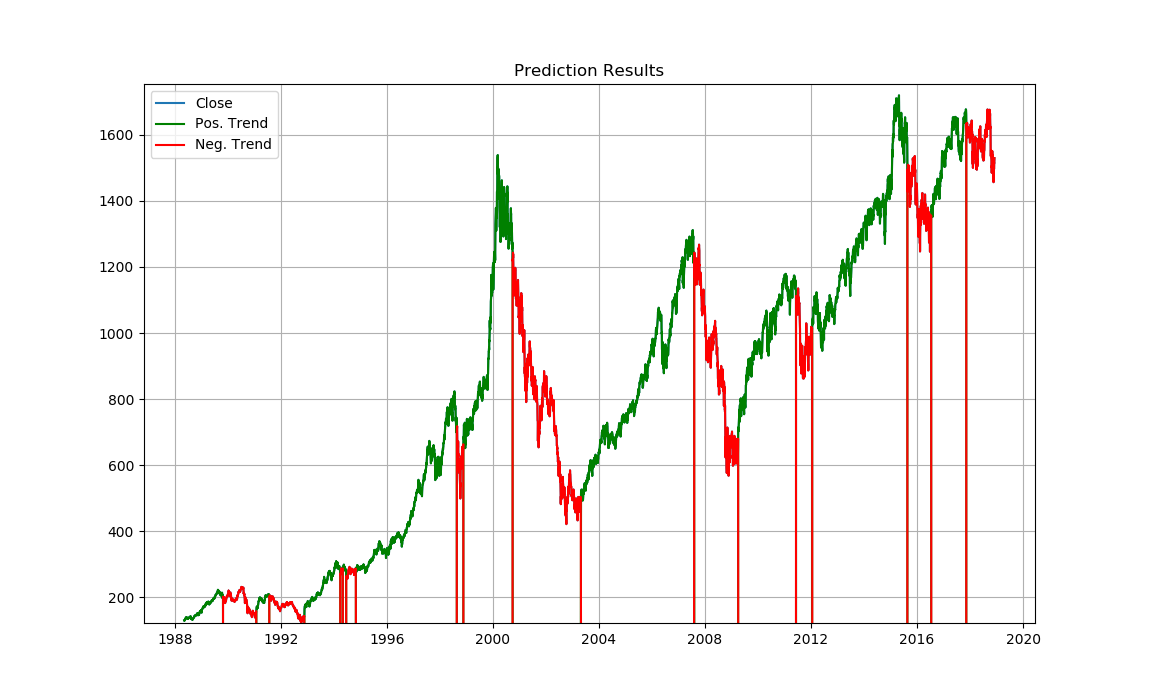

In [22]:
%matplotlib notebook

plot_data = amplifyForPlot(y_order_test_pred['y'].values-0.5, df_timegraph['Close'].values, 0.0)

inverse_values = (y_order_test_pred['y'].values-1)*(-1)

# Plot test data
plt.figure(num=None, figsize=(11.5, 7), dpi=80, facecolor='w', edgecolor='k')

plt.plot(df_timegraph['Time'], df_timegraph['Close'])
plt.plot(df_timegraph['Time'], amplifyForPlot(y_order_test_pred['y'].values, df_timegraph['Close'].values, 0.0), color='green')
plt.plot(df_timegraph['Time'], amplifyForPlot(inverse_values, df_timegraph['Close'].values, 0.0), color='red')
if display_labelled_data == True:
    plt.plot(df_timegraph['Time'], amplifyForPlot(y, df_timegraph['Close'].values, 0.0), color='yellow')
plt.title("Prediction Results")
plt.ylim([np.min(df_timegraph['Close'].values)*0.99, np.max(df_timegraph['Close'].values)*1.02])
plt.grid()
plt.legend(['Close', 'Pos. Trend', 'Neg. Trend', 'Pos. Trend true value'])
plt.show()

In [23]:
s = df_timegraph.join(y_order_test_pred['y'])
if display_labelled_data == True:
    s=s.join(df_y)
s.tail(50)

,Time,High,Low,Close,y
id,,,,,
8037,2018-09-25,1658.90,1650.38,1656.71,0
8038,2018-09-26,1658.83,1648.27,1658.29,0
8039,2018-09-27,1676.89,1649.48,1676.37,0
8040,2018-09-28,1674.91,1654.20,1662.36,0
8041,2018-10-01,1670.35,1657.08,1667.45,0
8042,2018-10-02,1665.90,1650.57,1656.90,0
8043,2018-10-03,1677.33,1658.73,1665.14,0
8044,2018-10-04,1664.80,1643.56,1648.96,0
8045,2018-10-05,1649.61,1633.68,1634.86,0
